In [1]:
import os, sys

colab = False
if os.path.abspath(".") == "/content":  # google colab
    %pip install sktime keras==2.8.0 tensorflow==2.8.2 keras-nlp==0.4.0 mlflow GitPython tensorflow_addons==0.17.1 databricks-cli  --quiet
    from google.colab import drive

    drive.mount("/content/drive")
    os.chdir("/content/drive/My Drive/master-thesis/src")
    colab = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.5/337.5 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 9.3 MB/s eta 0:00

In [2]:
import sys, os
from models import Encoder_model
from preprocessing import ConstantLengthDataGenerator, plot
from mlflow_logging import MlFlowLogging
from reading import ConcatenatedDataset
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import sklearn
import shutil
from sklearn.model_selection import train_test_split
import mlflow
import tensorflow as tf
import logging

In [3]:
mlflow.set_experiment("Encoder")

<Experiment: artifact_location='mlruns/983040006367495846', creation_time=1675105883005, experiment_id='983040006367495846', last_update_time=1675105883005, lifecycle_stage='active', name='Encoder', tags={}>

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
mlflow_logging = MlFlowLogging()
run = mlflow.start_run()
mlflow.tensorflow.autolog()

In [5]:
category = "MOTION"
X, y = ConcatenatedDataset().read_dataset(dataset="ECG200")

INFO:root:Loading only one dataset: ECG200
INFO:root:Loading only one dataset: ECG200


In [6]:
y_encoder = sklearn.preprocessing.OneHotEncoder(categories="auto")
y = y_encoder.fit_transform(y.reshape(-1, 1)).toarray()
mlflow.log_param("y.shape", y.shape)
y.shape, X.shape

((200, 2), (200,))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y)

# Model

In [8]:
number_of_classes = y.shape[1]
output_directory = f"./data/models/encoder/category={category}"
batch_size = 256
input_length = 256
os.makedirs(output_directory, exist_ok=True)

In [9]:
input_layer = keras.layers.Input(shape=(input_length, 1))
fcn_model = Encoder_model(number_of_classes=y.shape[1])(input_layer)
model = keras.models.Model(inputs=input_layer, outputs=fcn_model)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4, decay_steps=int(1e6), decay_rate=0.5
)

callbacks = []
callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=output_directory,
        monitor="val_accuracy",
        save_best_only=True,
        save_weigths_only=True,
    )
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr_schedule),
    metrics=["accuracy"],
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 128)     768         ['input_1[0][0]']                
                                                                                                  
 instance_normalization (Instan  (None, 256, 128)    256         ['conv1d[0][0]']                 
 ceNormalization)                                                                                 
                                                                                                  
 p_re_lu (PReLU)                (None, 256, 128)     128         ['instance_normalization[0][0

In [11]:
kwargs = {
    "min_length": input_length,
    "max_length": input_length,
    "logging_call": mlflow.log_params,
}
data_generator_train = ConstantLengthDataGenerator(
    X_train,
    y_train,
    batch_size=batch_size,
    augmentation_probability=0.2,
    cutting_probability=0.2,
    padding_probability=0.5,
    **kwargs
)
data_generator_val = ConstantLengthDataGenerator(
    X_val,
    y_val,
    batch_size=len(y_val),
    augmentation_probability=0,
    cutting_probability=0,
    padding_probability=1,
    **kwargs
)
validation_data = next(data_generator_val)

In [12]:
history = model.fit(
    data_generator_train,
    epochs=5,
    validation_data=validation_data,
    callbacks=callbacks,
)

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.7465 

INFO:tensorflow:Assets written to: ./data/models/encoder/category=MOTION/assets


10/10 [==============================] - 120s 12s/step - loss: 0.5012 - accuracy: 0.7465 - val_loss: 0.4496 - val_accuracy: 0.7200
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.7914 

INFO:tensorflow:Assets written to: ./data/models/encoder/category=MOTION/assets


10/10 [==============================] - 109s 11s/step - loss: 0.3821 - accuracy: 0.7914 - val_loss: 0.3222 - val_accuracy: 0.9000
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9078 

INFO:tensorflow:Assets written to: ./data/models/encoder/category=MOTION/assets


10/10 [==============================] - 118s 12s/step - loss: 0.2395 - accuracy: 0.9078 - val_loss: 0.2946 - val_accuracy: 0.9400
Epoch 4/5
10/10 [==============================] - 110s 11s/step - loss: 0.1843 - accuracy: 0.9375 - val_loss: 0.2654 - val_accuracy: 0.9200
Epoch 5/5
10/10 [==============================] - 114s 11s/step - loss: 0.1596 - accuracy: 0.9219 - val_loss: 0.2885 - val_accuracy: 0.9000


INFO:tensorflow:Assets written to: /tmp/tmphw178php/model/data/model/assets
2023/02/06 09:33:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmphw178php/model, flavor: tensorflow), fall back to return ['tensorflow==2.8.2']. Set logging level to DEBUG to see the full traceback.


# Logging the results

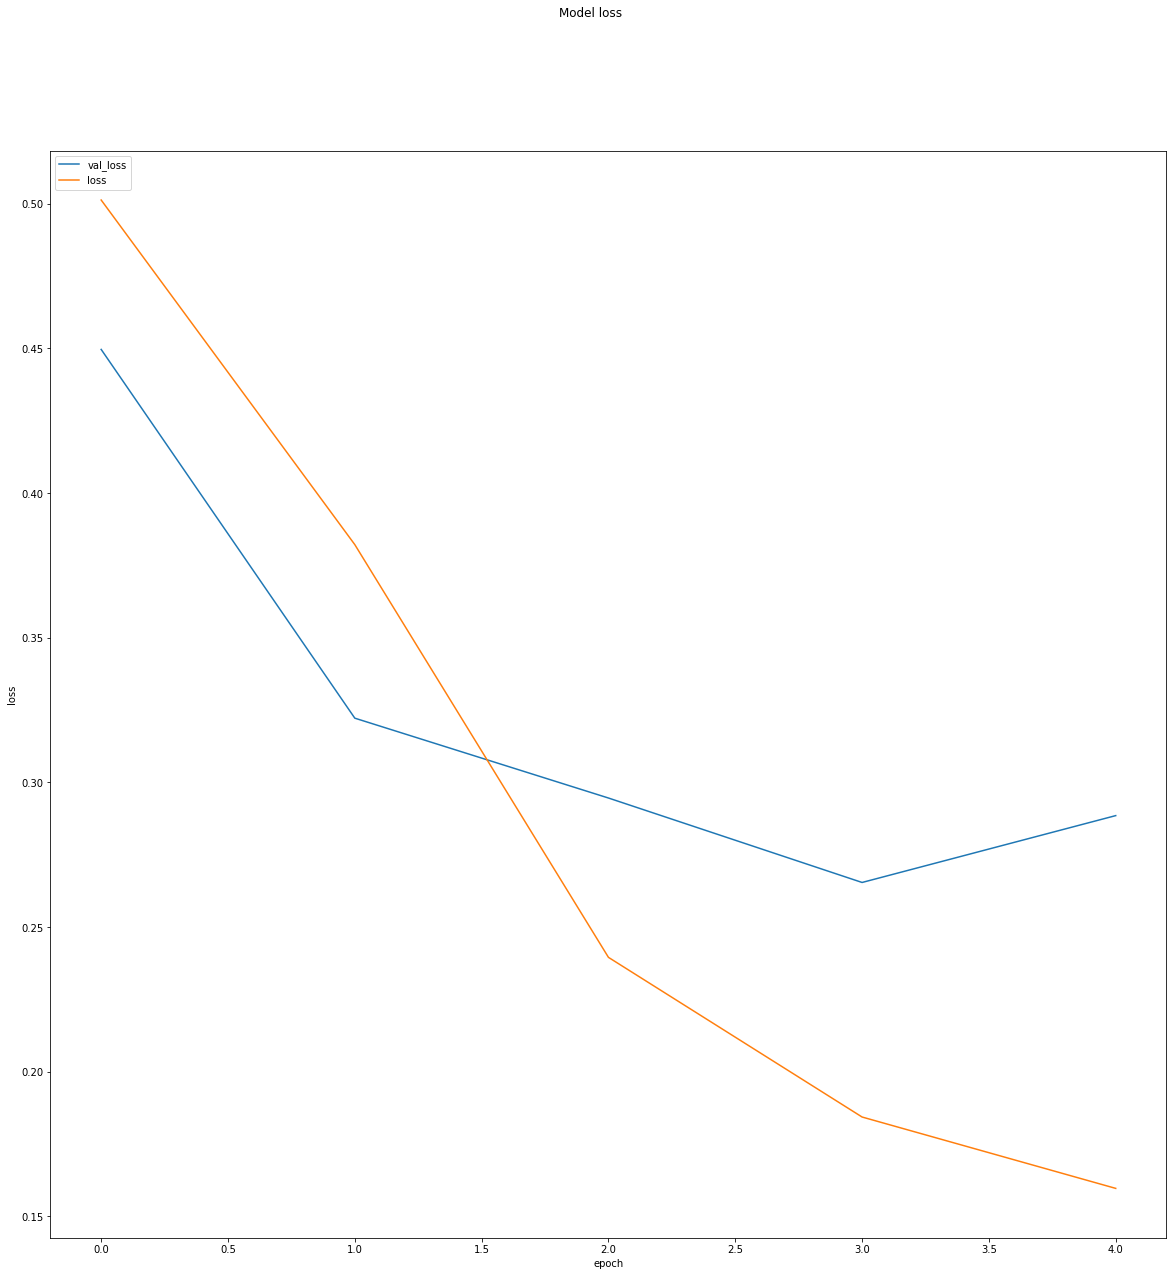

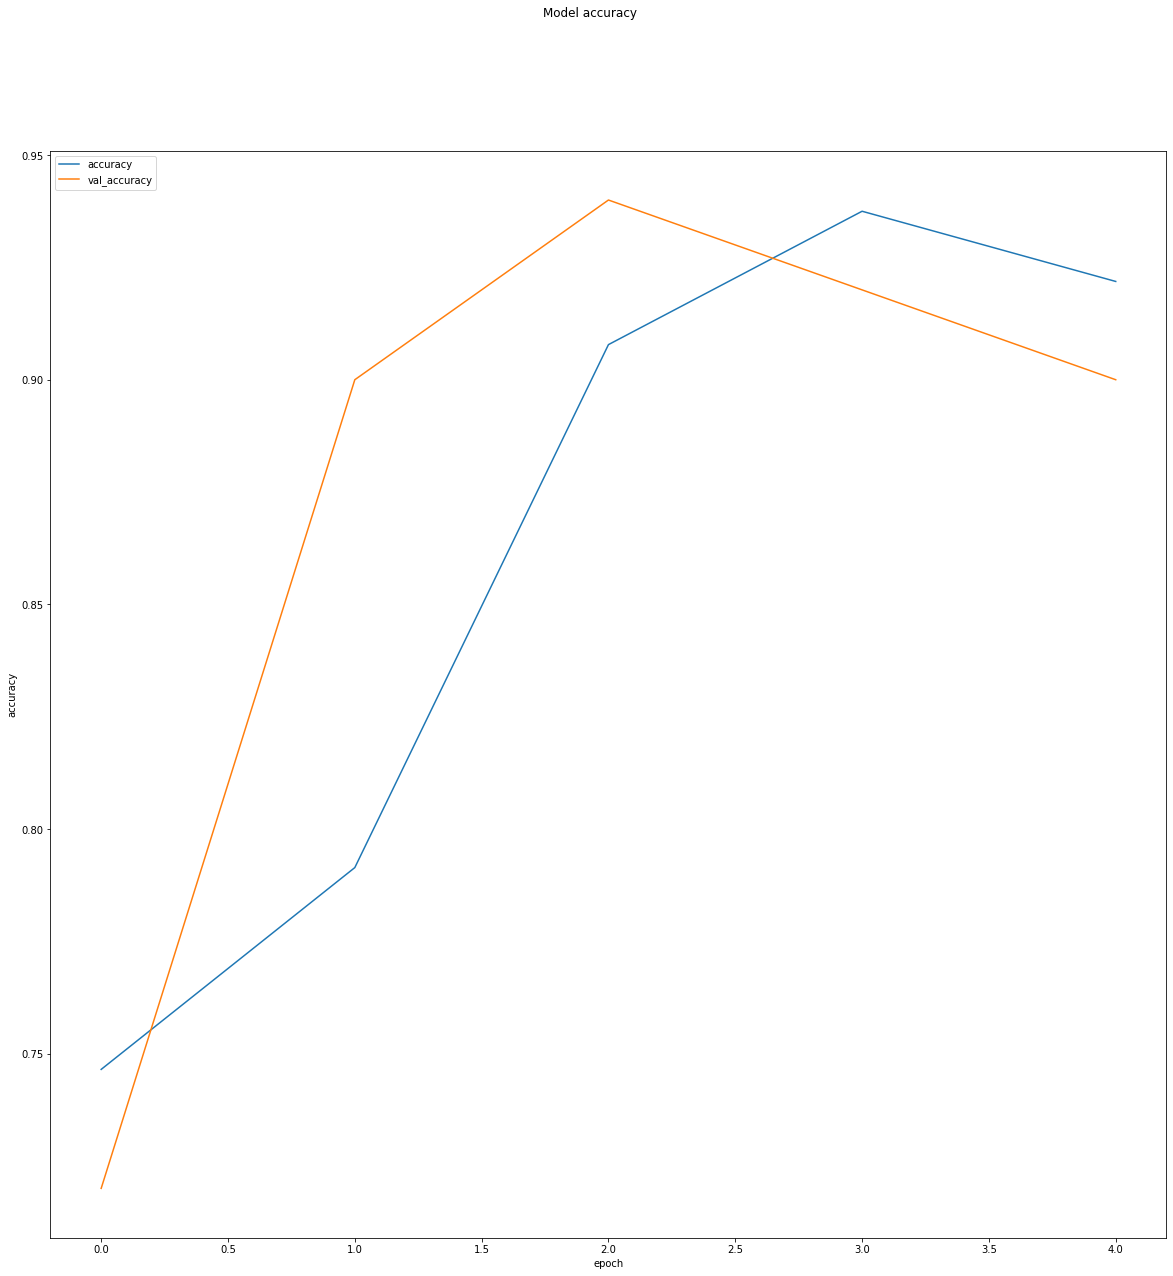

In [13]:
mlflow_logging.log_history(history.history)

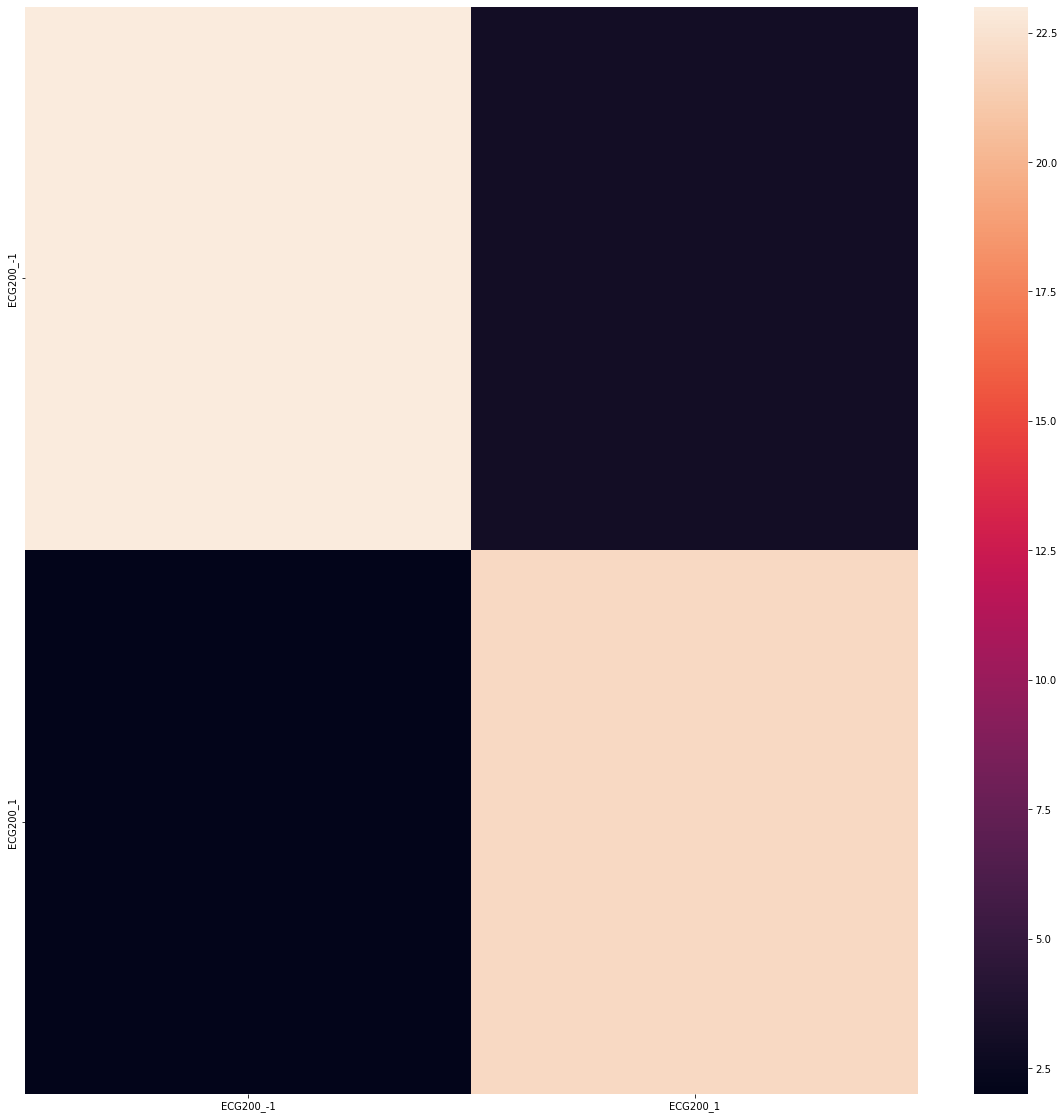

In [14]:
mlflow_logging.log_confusion_matrix(
    *validation_data, classifier=model, y_encoder=y_encoder
)

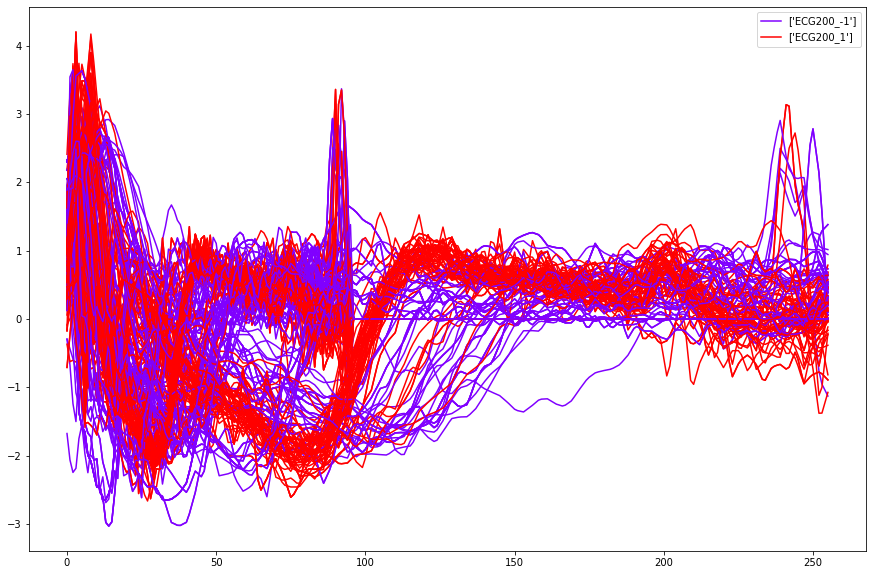

In [15]:
mlflow_logging.log_example_data(*next(data_generator_train), encoder=y_encoder)

In [16]:
run.info.artifact_uri

'mlruns/983040006367495846/8613c1e96ff24354a1546bb448eb2e4a/artifacts'

In [17]:
mlflow.end_run()